In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder

## Introduction

Here are some possible business questions:

- What factors contribute most heavily to the price? Make a model to predict the price - one that's interpretable and perhaps one (like a neural network) that's not interpretable but does a better job of price prediction.
- Which neighborhoods have the most variability in their listing prices over the course of the year? I'm curious about this because one strategy for making good money from airbnb is to live in an apartment most of the year, but make it available at times when it can fetch particularly high prices (and just sleep somewhere else on those nights, e.g. a cheap motel an hour outside town, or a campsite).
- What should those listings with poor overall review scores do in order to get better reviews in the future?
- What can we discern about the character of each neighborhood using the descriptions?

In [2]:
listings = pd.read_csv("listings.csv")
calendar = pd.read_csv("calendar.csv")

In [3]:
listings.iloc[[1]]['host_response_rate'].item() is np.nan

True

Definitions for many (though not all) of the fields can be found [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896).

Drop columns that have all `NA` values.

In [4]:
listings_na_cols = listings.columns[listings.isna().all()]
listings.drop(columns=listings_na_cols, inplace=True)
calendar.dropna(axis=1, how='all', inplace=True)

Drop rows in `listings` that have `NA` in the `price` field, and do the same for the `price` and `adjusted_price` fields in `calendar`.

In [5]:
listings.dropna(subset=['price'], inplace=True)
calendar.dropna(subset=['price', 'adjusted_price'], inplace=True)

Observe that a dollar sign preceeds the number in several columns; I will remove this so that the field is treated as numeric.

In [6]:
listings['price'] = listings.apply((lambda x: x['price'].replace('$','').
                                    replace(',','')), axis=1)
calendar['price'] = calendar.apply((lambda x: x['price'].replace('$','')
                                    .replace(',','')), axis=1)
calendar['adjusted_price'] = calendar.apply((lambda x: x['adjusted_price']
                                             .replace('$','').replace(',','')), axis=1)

The price should be greater than zero. I'll drop all rows where this is not the case.

In [7]:
listings['price'] = listings['price'].astype(np.float64)
calendar['price'] = calendar['price'].astype(np.float64)
calendar['adjusted_price'] = calendar['adjusted_price'].astype(np.float64)

In [8]:
listings.drop(listings.loc[listings['price'] <= 0].index, inplace=True)

Similarly, some of the fields are expressed as percentages; I will remove the percent signs and change the entries to floats.

In [9]:
listings['host_response_rate'] = listings.apply(lambda x: float(x['host_response_rate'].replace('%','')) if pd.notnull(x['host_response_rate']) else x['host_response_rate'], axis=1)
listings['host_acceptance_rate'] = listings.apply(lambda x: float(x['host_acceptance_rate'].replace('%','')) if pd.notnull(x['host_acceptance_rate']) else x['host_acceptance_rate'], axis=1)

# 1. Price prediction

## Data preparation

Split into `X` and `y`.

In [10]:
X = listings.drop('price', axis=1)
y = listings['price']

I also need to deal with dates appropriately. The relevant columns are `host_since`, `first_review`, and `last_review`. I could scrap these columns altogether, but it might be useful to know the length of time since the date for each row. 

In [11]:
for col in ['host_since', 'first_review', 'last_review']:
    X[col] = pd.to_datetime(X['last_scraped']) - pd.to_datetime(X[col])
    X[col] = X.apply(lambda x: x[col].days, axis=1)

Certain columns in `X` are not useful for prediction (for example, URLs), and should be removed.

In [12]:
to_drop = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name']
to_drop += ['description', 'neighborhood_overview', 'picture_url', 'host_id']
to_drop += ['host_url', 'host_name', 'host_about', 'host_thumbnail_url']
to_drop += ['host_picture_url', 'license', 'calendar_last_scraped']
X.drop(labels=to_drop, axis=1, inplace=True)

Certain columns (`host_verifications` and `amenities`) are lists of options; I'd like to split these into different columns.

The first step is to change these entries into actual Python lists instead of strings (annoyingly, the two relevant columns are formatted slightly differently, with the roles of single and double quotes being interchanged between them).

In [13]:
X['host_verifications'] = X.apply(lambda x: x['host_verifications'].replace('[','').replace(']','').replace('\'','').split(', '), axis=1)

In [14]:
X['amenities'] = X.apply(lambda x: x['amenities'].replace('\"','').replace('[','').replace(']','').split(', '), axis=1)

What are the possible values in the `host_verifications` lists?

In [15]:
distinct_host_verifications = set()
def find_distinct_hvs(x):
    for hv in x['host_verifications']:
        distinct_host_verifications.add(hv)
X.apply(lambda x: find_distinct_hvs(x), axis=1)
distinct_host_verifications = list(distinct_host_verifications)

In [16]:
len(distinct_host_verifications)

20

The `MultiLabelBinarizer` in `sklearn` works for splitting the lists into their individual elements, and then creating a dummy variable for each one (I started to write this myself, and then found that this convenient function exists in sklearn!).

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

In [18]:
mlb_hv = MultiLabelBinarizer()
hv_df = pd.DataFrame(mlb_hv.fit_transform(X['host_verifications']),
                     columns=mlb_hv.classes_, index=X.index)

In [19]:
X = pd.concat([X, hv_df], axis=1)

In [20]:
X.rename(columns={'None' : 'HV_None'}, inplace=True)
# I don't want a column to be called just 'None', so I changed it a bit

Now I can drop the original `host_verifications` column.

In [21]:
X.drop('host_verifications', axis=1, inplace=True)

Now I'd like to do the same for the `amenities` column. What are the possible values in those lists?

In [22]:
distinct_amenities = set()
def find_distinct_amenities(x):
    for a in x['amenities']:
        distinct_amenities.add(a)
X.apply(lambda x: find_distinct_amenities(x), axis=1)
len(distinct_amenities)

976

Ok, that's a lot of amenities. I don't really want to vastly blow up the number of features like this, so I'll just take the 20 most popular amenities.

In [23]:
from collections import defaultdict
from operator import itemgetter

In [24]:
amenity_counts = defaultdict(int) # Initializes to zero for each value
def update_counts(x):
    for a in x['amenities']:
        amenity_counts[a] += 1
X.apply(lambda x: update_counts(x), axis=1);

In [25]:
top_20 = sorted(amenity_counts.items(), key=itemgetter(1), reverse=True)[:20]

In [26]:
top_20[:5]

[('Smoke alarm', 6357),
 ('Essentials', 6185),
 ('Wifi', 6141),
 ('Kitchen', 5930),
 ('Carbon monoxide alarm', 5924)]

In [27]:
top_20_amenities = list(dict(top_20).keys())

Now I want to get rid of the other amenities in each row.

In [28]:
def find_amenities(x):
    amenities = []
    for a in top_20_amenities:
        if a in x['amenities']:
            amenities.append(a)
    return amenities

In [29]:
X['amenities'] = X.apply(lambda x: find_amenities(x), axis=1)

Now I can create the dummy variables and drop the original `amenities` column.

In [30]:
mlb_amenities = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb_amenities.fit_transform(X['amenities']),
                            columns=mlb_amenities.classes_, index=X.index)
X = pd.concat([X, amenities_df], axis=1)
X.drop('amenities', axis=1, inplace=True)

Next, I'll get dummies for the rest of the categorical variables.

A note: The Pandas `get_dummies()` method has the huge disadvantage that it can't be applied to new data; given a new instance I want to transform to be in the same format as the rows of X, I would have to append this to the end of `listings` and then do all the transformations for preparation again to the whole of X, which is horribly inefficient. Thankfully, sklearn's `OneHotEncoder` doesn't suffer from this shortcoming; it can be fit to X and used to transform any new data that comes in later for predictions.

I didn't realize this disadvantage until I tried to implement a data preparation pipeline at the end (for deployment).

In [31]:
X_cat = X.select_dtypes(include='object').copy()
cat_columns = X_cat.columns

In [32]:
X_cat.fillna(value="NA", inplace=True)

I'm chooing to replace nan values with "NA" in the categorical columns for a rather odd reason having to do with the application of sklearn's `OneHotEncoder`. It worked fine for me here; I can verify that the nan values in this dataframe are `np.nan` by using `value is np.nan` to check whether `value` is `np.nan`. But when I tried to apply it in my data preparation pipeline at the end (for deployment) using my `my_listing.csv` file, it gave me an error, saying "ufunc 'isnan' not supported for the input types." Testing a field there in the same way, I found that it was not `np.nan`, and even when I set it explicitly equal to `np.nan`, it still would not return `True` to `value is np.nan`! This is a weird implementation issue, it appears: `id(np.nan)` gives 4547092880 whereas the `id` of the nan value in question gave 5781442624 (I checked that this is not equal to `id(math.nan)` or `id(float('nan'))`). Quite annoying! I couldn't figure out how to set this pointer explicitly - I'm not sure that's something I can do without getting into ctypes. So I'm just going to replace nan values for these columns with the string 'NA', which will then be turned into its own category for each categorical column by `OneHotEncoder`.

In [33]:
one_hot = OneHotEncoder(dtype=np.int64, sparse=False)

In [34]:
X_onehot = pd.DataFrame(one_hot.fit_transform(X_cat),
                        columns=one_hot.get_feature_names_out(),
                        index = X.index)

In [35]:
X.drop(columns=cat_columns, inplace=True)

In [36]:
X = pd.concat([X, X_onehot], axis=1)

I need to deal with `NA` values for the numeric columns. There's no totally ideal way to do this, but to move forward I'll impute using the mean.

In [37]:
fill_mean = lambda col: col.fillna(col.mean())
X = X.apply(fill_mean)

In [38]:
# Keep the column means for later
X_col_means = X.mean(axis=0)

## Modeling and Some Evaluation

Split into train and test sets.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

Now, don't touch the test set until the end (use cross-validation to evaluate models before then). I don't want to bias myself by picking up patterns in the test set.

It will be useful for me to have a validation set (e.g. for plotting results to get a handle on what's going on) that I can access explicitly, instead of just the ones that `cross_val_score` uses in the course of its execution.

In [40]:
X_val_train, X_val, y_val_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

### Linear Model

Instantiate the model, including normalization in the pipeline:

In [41]:
pipe = make_pipeline(StandardScaler(), LinearRegression())

In [42]:
scores = cross_val_score(pipe, X, y)
print("Scores:")
print(scores)
print(f"Mean = {scores.mean():.3g}, Standard Error = {scores.std()/np.sqrt(5):.3g}")

Scores:
[-3.99473095e+27 -1.90373652e+24 -7.60171870e+25 -2.39366961e+27
 -2.58656876e+28]
Mean = -6.47e+27, Standard Error = 4.39e+27


Score the model on the validation set:

In [43]:
pipe.fit(X_val_train, y_val_train)
pipe.score(X_val, y_val)

-1.2515023338833046e+27

In [44]:
y_pred = pipe.predict(X_val)

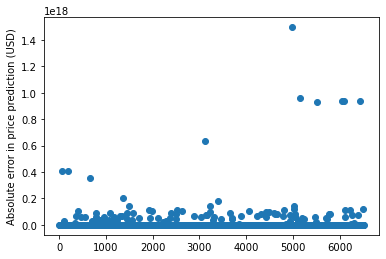

In [45]:
plt.plot(np.abs(y_val - y_pred), 'o')
plt.ylabel('Absolute error in price prediction (USD)')
plt.show()

Clearly some of the predictions are enormous and completely unreasonable. I think I need to aggressively get rid of features to correct this - I have way too many categorical variables that don't occur often and are not very relevant to price prediction.

Here are some functions to do this conveniently, as well as evaluate models using cross-validation.

In [46]:
def fit_model(X, y, model, cutoff=False, return_X_cutoff=False):
    pipe = make_pipeline(StandardScaler(), model)
    if cutoff is False:
        cutoff = -1
    # Only keep features for which the average absolute value
    # over all samples exceeds some cutoff
    to_keep = np.where(np.abs(X.sum()/len(X)) > cutoff)[0]
    X_cutoff = X.iloc[:, to_keep]
    y_pred = cross_val_predict(pipe, X_cutoff, y)
    if return_X_cutoff:
        return y_pred, X_cutoff
    else:
        return y_pred

In [47]:
def do_cutoff(X, cutoff):
    X_cutoff = X.iloc[:, np.where(np.abs(X.sum()/len(X)) > cutoff)[0]]
    return X_cutoff

In [48]:
def score_model(X, y, model, cutoff, return_n_features=False, random_state=42, scoring=None):
    ''' Evaluates `model` on X, y using cross-validation and a scoring function.
    If `scoring=None` then the scoring function in sklearn's implementation of 
    `model` is used.
    Optionally, the number of features in the training set can be returned.
    This is done if return_n_features=True.
    '''
    pipe = make_pipeline(StandardScaler(), model)
    X_cutoff = do_cutoff(X, cutoff)
    scores = cross_val_score(pipe, X_cutoff, y, scoring=scoring)
    if return_n_features:
        return scores, X_cutoff.shape[1]
    else:
        return scores

In [49]:
def test_cutoffs(X, y, model, cutoffs, scoring=None, print_results=True):
    ''' Loops through different cutoffs on the number of features.
    '''
    results = {}
    for cutoff in cutoffs:
        scores, n_features = score_model(X, y, model, cutoff, return_n_features=True, scoring=scoring)
        if print_results:
            print(f"Cutoff = {cutoff:.3g}, Mean score = {scores.mean():.3g}, Standard error = {scores.std()/np.sqrt(5):.3g}, n_features = {n_features}")
    return scores

In [201]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs);

Cutoff = 1e+03, Mean score = -0.0687, Standard error = 0.0629, n_features = 4
Cutoff = 1, Mean score = -0.726, Standard error = 0.702, n_features = 38
Cutoff = 0.9, Mean score = -1.44, Standard error = 1.45, n_features = 47
Cutoff = 0.7, Mean score = -2.14, Standard error = 2.16, n_features = 63
Cutoff = 0.3, Mean score = -7.15e+16, Standard error = 6.4e+16, n_features = 79
Cutoff = 0.1, Mean score = -1.55e+21, Standard error = 1.38e+21, n_features = 92
Cutoff = 0.05, Mean score = -5.42e+23, Standard error = 4.85e+23, n_features = 107
Cutoff = 0.01, Mean score = -2.7e+22, Standard error = 2.41e+22, n_features = 174
Cutoff = 0.005, Mean score = -1.34e+22, Standard error = 1.2e+22, n_features = 211
Cutoff = 0.003, Mean score = -3.7e+21, Standard error = 3.31e+21, n_features = 242
Cutoff = 0.001, Mean score = -4.33e+24, Standard error = 3.12e+24, n_features = 314
Cutoff = 0, Mean score = -2.5e+27, Standard error = 1.62e+27, n_features = 680


Many of these CV scores are horrific; none of the models have better coefficient of determination than a model that just predicts the mean price every time. And there's another problem: many of the predicted prices are negative!

In [51]:
y_pred_L = fit_model(X_train, y_train, LinearRegression(), 0.01)

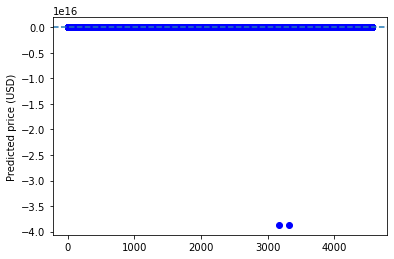

In [52]:
plt.plot(y_pred_L, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

Thinking about what I actually want from my model, I don't care so much if there are a few outliers for which price predictions are very poor. I'm more concerned with the *median* absolute fractional error, not the *mean* absolute error. I'll express this as a percent.

In [206]:
def median_abs_pct_err(y_true, y_pred):
    return 100*np.abs((y_true - y_pred)/y_true).median()

In [54]:
median_abs_pct_err(y_train, y_pred_L)

482.47802616730695

Still quite awful: half of the predictions are off by over 400%.

In [207]:
median_scorer = make_scorer(median_abs_pct_err)

In [56]:
def df_pct_abs_err(y_pred, y_true, plot=False, plot_cutoff=300):
    df = pd.DataFrame(100*np.abs((y_true - y_pred)/y_true))
    df = df.rename(columns={'price':'pct_abs_err'})
    if plot:
        df[df['pct_abs_err'] < plot_cutoff].hist()
        plt.ylabel("Number of occurrences")
        plt.xlabel("Absolute error in price prediction (%)")
        plt.title
        plt.show()
    return df

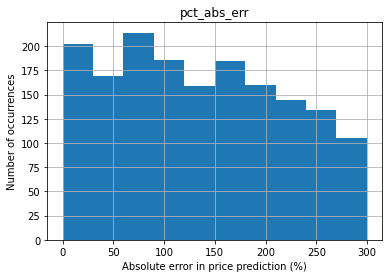

482.4780261673069

In [57]:
df_pct_abs_err(y_pred_L, y_train, plot=True).median().item()

In [58]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 147, Standard error = 10.1, n_features = 4
Cutoff = 1, Mean score = 314, Standard error = 24.7, n_features = 38
Cutoff = 0.9, Mean score = 311, Standard error = 15.6, n_features = 47
Cutoff = 0.7, Mean score = 414, Standard error = 26, n_features = 63
Cutoff = 0.3, Mean score = 426, Standard error = 22.1, n_features = 79
Cutoff = 0.1, Mean score = 465, Standard error = 29.8, n_features = 92
Cutoff = 0.05, Mean score = 467, Standard error = 29.8, n_features = 107
Cutoff = 0.01, Mean score = 487, Standard error = 25.4, n_features = 174
Cutoff = 0.005, Mean score = 483, Standard error = 26.7, n_features = 211
Cutoff = 0.003, Mean score = 492, Standard error = 27.5, n_features = 242
Cutoff = 0.001, Mean score = 507, Standard error = 20.9, n_features = 314
Cutoff = 0, Mean score = 613, Standard error = 33.8, n_features = 680


These mean scores are the mean of the median absolute percentage error, computed across the five cross-validation folds.

### Dealing with Outliers

If a listing has an absurdly high price that isn't reflective of what people will actually pay, or just isn't that relevant for a typical person who wants to list their place, that isn't good for the usefulness of our model. Models that are trained using $L^2$ loss, including `LinearRegression()`, penalize outliers (in the target variable) very sharply, which can be problematic for training (i.e. mimizing the mean-squared loss). Therefore, I'll take a look at places that have extremely high prices and see if it makes sense to remove them.

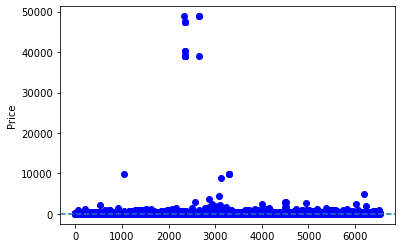

In [59]:
plt.plot(listings['price'], 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel("Price")
plt.show()

Yeah, some of these prices look like they might be absurd.

In [60]:
listings['price'].sort_values(ascending=False).head(30)

2648    48864.0
2647    48864.0
2341    48864.0
2360    47484.0
2361    47484.0
2359    47484.0
2362    47484.0
2346    40356.0
2345    40356.0
2350    39132.0
2355    39132.0
2351    39132.0
2356    39132.0
2353    39132.0
2650    39132.0
2354    39132.0
2352    39132.0
2358    39132.0
2357    39132.0
3288     9999.0
1049     9999.0
3287     9999.0
3289     9999.0
3120     9000.0
6196     5000.0
3072     4500.0
2866     3690.0
4522     3070.0
4498     3042.0
2570     3000.0
Name: price, dtype: float64

In [61]:
# Find the URL of one of the most expensive places
listings.loc[2648, 'listing_url']

'https://www.airbnb.com/rooms/30718928'

What is going on here? Following the link above, this is clearly a luxury place, but it's just a studio! On top of that, it's currently listed at USD 1,653 per night (as of December 3, 2021), not USD 48,864 per night as above. Let's take a closer look at `calendar` to see what happened:

In [62]:
listing_id = listings.loc[2648, 'id']

In [63]:
calendar.loc[calendar['listing_id']==listing_id, ['date', 'price', 'adjusted_price']]

,date,price,adjusted_price
1020296,2021-10-18,8144.0,48864.0
1020297,2021-10-19,8144.0,48864.0
1020298,2021-10-20,8144.0,48864.0
1020299,2021-10-21,8144.0,48864.0
1020300,2021-10-22,8144.0,48864.0
...,...,...,...
1023099,2022-10-13,263.0,1578.0
1023100,2022-10-14,307.0,1842.0
1023101,2022-10-15,307.0,1842.0
1023102,2022-10-16,263.0,1578.0


OK, it appears that the adjusted price was very high in mid-October, and that's what was pulled into the `price` field in `listings`. My understanding is that Airbnb allows hosts to turn on a setting that automatically adjusts the price according to demand (using some model developed by Airbnb), so likely demand was extremely high at nearby properties at that time. In any case, it would make sense for me to exclude this property and related ones from my data; I note that each of the properties over USD 10,000 are in the "Ginosi 747 Apartel", as can be easily verified by clicking on those URLs. Further, one of the next most expensive listings, at USD 9,999, is a 12-bedroom mansion.

Now I'll delete these outliers (those listings with prices above USD 10,000 per night). It makes sense to do this across all the data (not just for the training data), since I'm not interested in making predictions for places where the price would be that high (totally out of whack with what almost everyone would pay - prices that would actually banned by law for similar hotel accommodations), and I'd like to use all the data to create my final model.

In [64]:
to_drop = y[y > 10000].index

In [65]:
# Drop the necessary rows
X.drop(to_drop, inplace=True)
y.drop(to_drop, inplace=True)
# Drop the rows from the original dataframe as well (since I'll use this dataframe
# again shortly)
listings.drop(to_drop, inplace=True)

In [66]:
# Do the train-test splits again
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val_train, X_val, y_val_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

### Linear Model, Again

In [67]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs);

Cutoff = 1e+03, Mean score = -0.00261, Standard error = 0.00357, n_features = 4
Cutoff = 1, Mean score = 0.354, Standard error = 0.0511, n_features = 38
Cutoff = 0.9, Mean score = 0.356, Standard error = 0.0494, n_features = 47
Cutoff = 0.7, Mean score = 0.354, Standard error = 0.0488, n_features = 63
Cutoff = 0.3, Mean score = 0.361, Standard error = 0.049, n_features = 79
Cutoff = 0.1, Mean score = 0.38, Standard error = 0.0495, n_features = 93
Cutoff = 0.05, Mean score = 0.387, Standard error = 0.0498, n_features = 106
Cutoff = 0.01, Mean score = 0.398, Standard error = 0.0529, n_features = 175
Cutoff = 0.005, Mean score = 0.404, Standard error = 0.0538, n_features = 216
Cutoff = 0.003, Mean score = 0.392, Standard error = 0.051, n_features = 243
Cutoff = 0.001, Mean score = -5.94e+24, Standard error = 3.83e+24, n_features = 319
Cutoff = 0, Mean score = -1.93e+26, Standard error = 5.48e+25, n_features = 674


In [68]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 58.9, Standard error = 1.71, n_features = 4
Cutoff = 1, Mean score = 41, Standard error = 1.25, n_features = 38
Cutoff = 0.9, Mean score = 41.1, Standard error = 1.22, n_features = 47
Cutoff = 0.7, Mean score = 42.3, Standard error = 1.03, n_features = 63
Cutoff = 0.3, Mean score = 41.3, Standard error = 1.05, n_features = 79
Cutoff = 0.1, Mean score = 41.2, Standard error = 1.04, n_features = 93
Cutoff = 0.05, Mean score = 41.2, Standard error = 0.829, n_features = 106
Cutoff = 0.01, Mean score = 38.6, Standard error = 0.673, n_features = 175
Cutoff = 0.005, Mean score = 39.7, Standard error = 0.742, n_features = 216
Cutoff = 0.003, Mean score = 39.6, Standard error = 0.999, n_features = 243
Cutoff = 0.001, Mean score = 37.2, Standard error = 0.629, n_features = 319
Cutoff = 0, Mean score = 41.6, Standard error = 0.712, n_features = 674


In [69]:
y_pred_L = fit_model(X_train, y_train, LinearRegression(), cutoff=0.001)

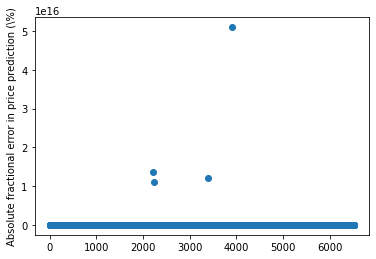

In [70]:
plt.plot(100*np.abs(y_train - y_pred_L)/y_train, 'o')
plt.ylabel('Absolute fractional error in price prediction (\%)')
plt.show()

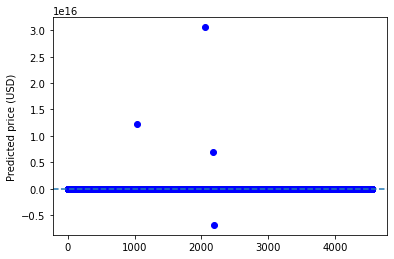

In [71]:
plt.plot(y_pred_L, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

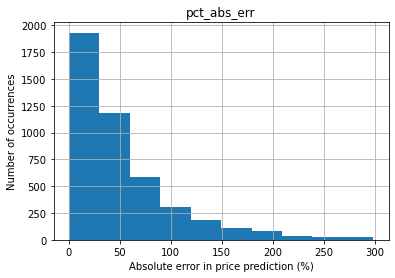

In [72]:
df_err_L = df_pct_abs_err(y_pred_L, y_train, plot=True)

In [73]:
df_err_L['pct_abs_err'].median()

37.34003824277923

That is, 50% of predictions are off from the true price by less than 40%.

This is certainly better than the previous model, though still not great, and a fair number of the predictions are still negative.

### Smaller Linear Model and some visualizations

What happens if I just use a smaller model? Maybe the one above is too big and has a lot of unnecessary features, even using cutoffs as above. What do we expect to be the most useful factors for price prediction? My guesses for the most important: Its size (number of people, number of bedrooms and bathrooms), the property type (entire home, condo, etc.) and/or room type, and the neighborhood.

To start off, I'll do some visualizations to gain intuition about the importance of these features. I think violin plots are a good way to do this - they are an effective way to get a quick idea of the price distribution for different groups just by looking.

First, I'll take a look at the effect of the neighborhood on the price. I'll restrict to the 10 neighborhoods with the most listings so the x-axis isn't too crowded, and I'll cut the prices off at USD 300 so that the distributions are easy to see.

In [113]:
top_10_nbds = listings['neighbourhood_cleansed'].value_counts()[:10].index

In [114]:
df = listings.loc[listings['neighbourhood_cleansed'].isin(top_10_nbds)]
df = df.loc[df['price'] < 300]

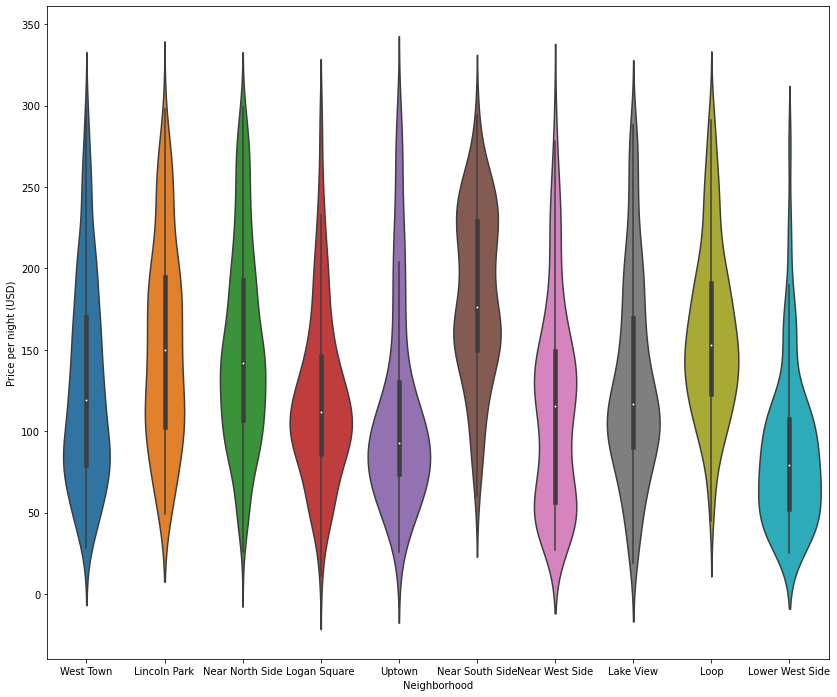

In [117]:
plt.figure(figsize=(14,12))
sns.violinplot(data=df, x='neighbourhood_cleansed', y='price')
plt.xlabel('Neighborhood')
plt.ylabel('Price per night (USD)')
plt.savefig('neighborhood_vs_price.jpg')
plt.show()

The price definitely has a reasonable degree of dependence on the neighborhood. Near South Side listings command particularly high prices, and Lower West Side listings particularly low ones. Of course, a problem here is that I'm not controlling for other factors, such as the size of the property. For example, maybe properties on the Near South Side have more bedrooms on average, and properties on the Lower West Side have fewer; then a possibility is that the number of bedrooms strongly affects the price, and the neighborhood's effect is just incidental. Still, it's useful to see the correlation between neighborhood and price, at least for gaining some intuition and thinking of further questions to pose.

Next I'll take a look at how the number of bedrooms affects the price.

In [118]:
top_bedrooms = listings['bedrooms'].value_counts()[:6].index

In [119]:
df = listings.loc[listings['bedrooms'].isin(top_bedrooms)]
df = df.loc[df['price'] < 300]

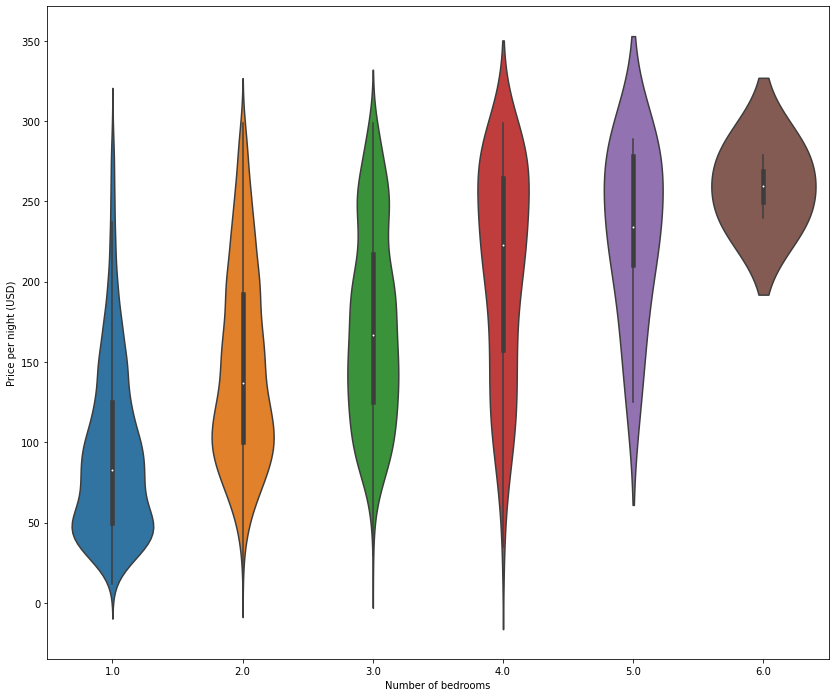

In [120]:
plt.figure(figsize=(14,12))
sns.violinplot(data=df, x='bedrooms', y='price')
plt.xlabel('Number of bedrooms')
plt.ylabel('Price per night (USD)')
plt.savefig('bedrooms_vs_price.jpg')
plt.show()

Number of bedrooms is highly positively correlated with price, as expected.

How about the effect of the room type?

In [121]:
room_types = listings['room_type'].value_counts().index

In [122]:
df = listings.loc[listings['room_type'].isin(room_types)]
df = df.loc[df['price'] < 300]

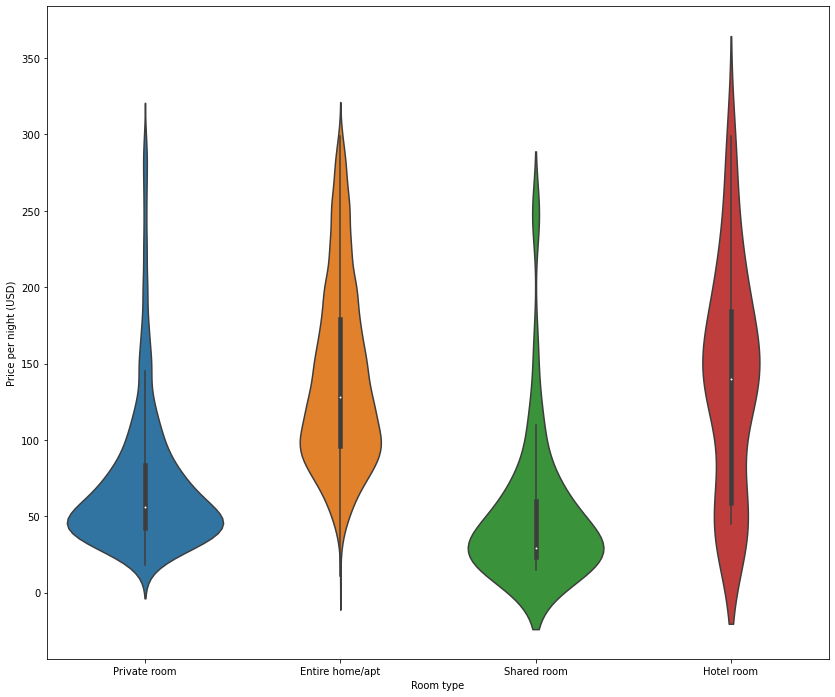

In [123]:
plt.figure(figsize=(14,12))
sns.violinplot(data=df, x='room_type', y='price')
plt.xlabel('Room type')
plt.ylabel('Price per night (USD)')
plt.savefig('room_type_vs_price.jpg')
plt.show()

As one would expect, shared rooms tend to have lower prices, and entire homes/apartments tend to have higher ones.

I feel reasonably justified in my choice of features for this smaller training set. So let's go ahead with it:

In [74]:
X_small = listings[['neighbourhood_cleansed','accommodates',
                    'bathrooms_text','bedrooms','beds',
                   'property_type', 'room_type']]

In [75]:
X_small = pd.get_dummies(X_small, drop_first=True)

In [76]:
y_small = y.copy()

I need to deal with the `NA` entries in `beds` and `bedrooms`.

In [77]:
X_small['bedrooms'] = X_small.apply(lambda x: x['beds'] if not(x['bedrooms']>0) else x['bedrooms'], axis=1)
X_small['beds'] = X_small.apply(lambda x: x['bedrooms'] if not(x['beds']>0) else x['beds'], axis=1)

In [78]:
sum(X_small.isna()['beds'])

4

In [79]:
X_small.loc[X_small.isna()['bedrooms']]

,accommodates,bedrooms,beds,neighbourhood_cleansed_Archer Heights,neighbourhood_cleansed_Armour Square,neighbourhood_cleansed_Ashburn,neighbourhood_cleansed_Auburn Gresham,neighbourhood_cleansed_Austin,neighbourhood_cleansed_Avalon Park,neighbourhood_cleansed_Avondale,...,property_type_Shared room in condominium (condo),property_type_Shared room in hostel,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in residential home,property_type_Shared room in serviced apartment,property_type_Tiny house,room_type_Hotel room,room_type_Private room,room_type_Shared room
5590,2,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6015,4,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6416,2,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6516,4,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


If a listing accommodates 0 people, I'll drop it.

In [80]:
to_drop = X_small.loc[X_small['accommodates'] == 0].index
X_small.drop(to_drop, inplace=True)
y_small.drop(to_drop, inplace=True)

If a listing x has NaN for `beds`, then I'll set x['beds'] = x['accommodates']/2 for that
row (i.e. guess the number of beds is half the number of people accommodated), and similarly
for `bedrooms`.

In [81]:
X_small['bedrooms'] = X_small.apply(lambda x: x['accommodates']/2 if not(x['bedrooms'] > 0) else x['bedrooms'], axis=1)
X_small['beds'] = X_small.apply(lambda x: x['accommodates']/2 if not(x['beds'] > 0) else x['beds'], axis=1)

In [82]:
sum(X_small.isna()['bedrooms'])

0

In [83]:
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(
    X_small, y_small, test_size=0.3, random_state=42)

In [84]:
cutoffs = [1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0.0005, 0]
test_cutoffs(X_small_train, y_small_train, LinearRegression(), cutoffs);

Cutoff = 1, Mean score = 0.313, Standard error = 0.045, n_features = 3
Cutoff = 0.9, Mean score = 0.313, Standard error = 0.045, n_features = 3
Cutoff = 0.7, Mean score = 0.313, Standard error = 0.045, n_features = 3
Cutoff = 0.3, Mean score = 0.314, Standard error = 0.045, n_features = 5
Cutoff = 0.1, Mean score = 0.348, Standard error = 0.0476, n_features = 12
Cutoff = 0.05, Mean score = 0.365, Standard error = 0.0473, n_features = 19
Cutoff = 0.01, Mean score = 0.384, Standard error = 0.0501, n_features = 52
Cutoff = 0.005, Mean score = 0.389, Standard error = 0.0523, n_features = 68
Cutoff = 0.003, Mean score = 0.392, Standard error = 0.0512, n_features = 83
Cutoff = 0.001, Mean score = 0.396, Standard error = 0.053, n_features = 107
Cutoff = 0.0005, Mean score = 0.395, Standard error = 0.0533, n_features = 118
Cutoff = 0, Mean score = -3.67e+23, Standard error = 1.87e+23, n_features = 150


In [85]:
cutoffs = [1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0.0005, 0]
test_cutoffs(X_small_train, y_small_train, LinearRegression(), cutoffs, scoring=median_scorer);

Cutoff = 1, Mean score = 43, Standard error = 0.834, n_features = 3
Cutoff = 0.9, Mean score = 43, Standard error = 0.834, n_features = 3
Cutoff = 0.7, Mean score = 43, Standard error = 0.834, n_features = 3
Cutoff = 0.3, Mean score = 44.9, Standard error = 0.846, n_features = 5
Cutoff = 0.1, Mean score = 41.5, Standard error = 0.857, n_features = 12
Cutoff = 0.05, Mean score = 41.5, Standard error = 0.657, n_features = 19
Cutoff = 0.01, Mean score = 37.7, Standard error = 0.652, n_features = 52
Cutoff = 0.005, Mean score = 37.3, Standard error = 0.749, n_features = 68
Cutoff = 0.003, Mean score = 36.8, Standard error = 0.882, n_features = 83
Cutoff = 0.001, Mean score = 33.9, Standard error = 0.671, n_features = 107
Cutoff = 0.0005, Mean score = 33.7, Standard error = 0.734, n_features = 118
Cutoff = 0, Mean score = 32.5, Standard error = 0.838, n_features = 150


Not bad! It looks like I guessed some of the most important factors correctly, getting a better score than my best linear model that includes all the features.

In [86]:
y_pred_small = fit_model(X_small_train, y_small_train, LinearRegression(), cutoff=0)

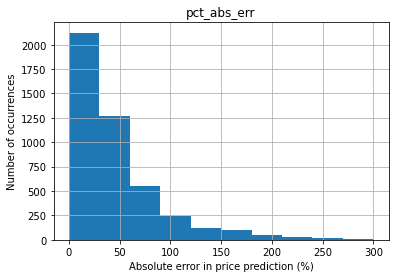

32.59871035260987

In [87]:
df_pct_abs_err(y_pred_small, y_small_train, plot=True).median().item()

### Elastic Net

There are more sophisticated models that help me get rid of irrelevent features by setting their weights to zero in the model. I'll use sklearn's `ElasticNet`, which has this favorable Lasso property while also having the L2 regularization properties of ridge regression.

In [50]:
from sklearn.linear_model import ElasticNet

In [89]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, ElasticNet(), cutoffs);

Cutoff = 1e+03, Mean score = -0.00344, Standard error = 0.00336, n_features = 4
Cutoff = 1, Mean score = 0.349, Standard error = 0.0496, n_features = 38
Cutoff = 0.99, Mean score = 0.348, Standard error = 0.0496, n_features = 40
Cutoff = 0.5, Mean score = 0.358, Standard error = 0.0487, n_features = 73
Cutoff = 0.3, Mean score = 0.36, Standard error = 0.0491, n_features = 79
Cutoff = 0.2, Mean score = 0.36, Standard error = 0.0493, n_features = 84
Cutoff = 0.1, Mean score = 0.376, Standard error = 0.0508, n_features = 93
Cutoff = 0.05, Mean score = 0.382, Standard error = 0.0501, n_features = 106
Cutoff = 0.01, Mean score = 0.393, Standard error = 0.0529, n_features = 175
Cutoff = 0.005, Mean score = 0.398, Standard error = 0.0521, n_features = 216
Cutoff = 0.002, Mean score = 0.399, Standard error = 0.0524, n_features = 259
Cutoff = 0.001, Mean score = 0.429, Standard error = 0.0552, n_features = 319
Cutoff = 0.0005, Mean score = 0.428, Standard error = 0.0536, n_features = 376
Cutoff

In [90]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, ElasticNet(), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 59.2, Standard error = 1.72, n_features = 4
Cutoff = 1, Mean score = 38.6, Standard error = 0.807, n_features = 38
Cutoff = 0.99, Mean score = 38.6, Standard error = 0.809, n_features = 40
Cutoff = 0.5, Mean score = 37.8, Standard error = 1.14, n_features = 73
Cutoff = 0.3, Mean score = 38, Standard error = 1.16, n_features = 79
Cutoff = 0.2, Mean score = 37.6, Standard error = 1.16, n_features = 84
Cutoff = 0.1, Mean score = 36.3, Standard error = 0.992, n_features = 93
Cutoff = 0.05, Mean score = 35.5, Standard error = 0.765, n_features = 106
Cutoff = 0.01, Mean score = 34.2, Standard error = 0.811, n_features = 175
Cutoff = 0.005, Mean score = 34.1, Standard error = 0.626, n_features = 216
Cutoff = 0.002, Mean score = 33.7, Standard error = 0.62, n_features = 259
Cutoff = 0.001, Mean score = 32.8, Standard error = 0.638, n_features = 319
Cutoff = 0.0005, Mean score = 32.6, Standard error = 0.49, n_features = 376
Cutoff = 0, Mean score = 31.8, Standard er

Not significantly better than my smaller linear model above.

In [91]:
y_pred_E = fit_model(X_train, y_train, ElasticNet(), cutoff=0)

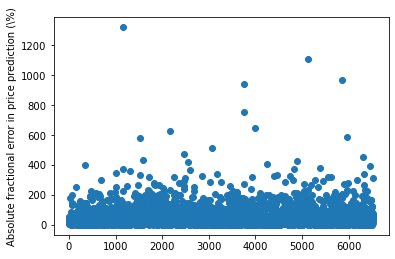

In [92]:
plt.plot(100*np.abs(y_train - y_pred_E)/y_train, 'o')
plt.ylabel('Absolute fractional error in price prediction (\%)')
plt.show()

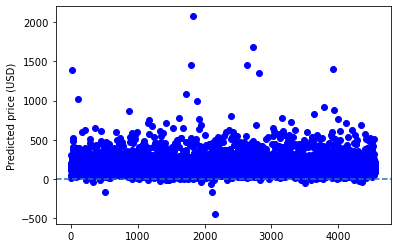

In [93]:
plt.plot(y_pred_E, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

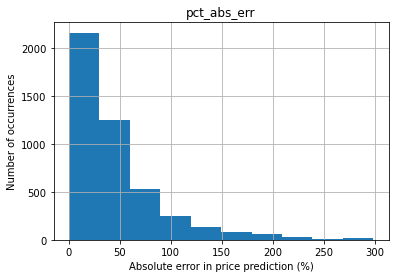

In [94]:
df_err_E = df_pct_abs_err(y_pred_E, y_train, plot=True)

In [95]:
df_err_E.median().item()

31.725522431859346

The CV score (mean $R^2$ between folds) and the median absolute error have both improved, though not substantially.

What are the most important features? For these results to be robust, I average the coefficients over the five folds obtained during cross-validation.

In [96]:
pipe = make_pipeline(StandardScaler(), ElasticNet())

In [97]:
cv_dict = cross_validate(pipe, X_train, y_train, return_estimator=True)
estimators = cv_dict['estimator']
coeffs = np.zeros(X_train.shape[1])
for i in range(5):
    coeffs += estimators[i].named_steps['elasticnet'].coef_
coeffs /= 5

In [98]:
df = pd.DataFrame(np.array([X_train.columns, coeffs, np.abs(coeffs)]).T, columns=['feature','coeff', 'abs_coeff'])
df = df.sort_values(by='abs_coeff', ascending=False)
df.head(30)

,feature,coeff,abs_coeff
748,bathrooms_text_6 baths,28.397859,28.397859
7,accommodates,23.630786,23.630786
8,bedrooms,22.884503,22.884503
9,beds,20.725773,20.725773
732,bathrooms_text_10 baths,19.125802,19.125802
749,bathrooms_text_6.5 baths,15.862419,15.862419
742,bathrooms_text_3.5 baths,13.896809,13.896809
750,bathrooms_text_7 baths,13.2234,13.2234
745,bathrooms_text_4.5 baths,12.697673,12.697673
476,host_neighbourhood_Lake View,12.392138,12.392138


Interestingly, the top 20 features or so all have positive coefficients, except for one (the "only one bathroom" feature). The larger the values of those features are, the larger we expect the price to be.

As was hinted at by smaller linear model above, the most important features are related to the number of bedrooms, number of bathrooms (in particular, having more than one), offering the entire home, and being in a desirable neighborhood for travelers. `availability_30`, the number of days in the next 30 days for which a property is available, also has an impact on raising the price.

In [99]:
X_top_20 = X[df[:20]['feature']].copy()

In [100]:
X_top_20_train, X_top_20_test, y_top_20_train, y_top_20_test = train_test_split(
    X_top_20, y, test_size=0.3, random_state=42)

Note that ElasticNet eliminates some features by setting their coefficients to zero.

In [101]:
len(df.loc[df['abs_coeff']==0])

156

In [102]:
X_E = X.drop(list(df.loc[df['abs_coeff']==0, 'feature']), axis=1)

In [103]:
X_E_train, X_E_test, y_E_train, y_E_test = train_test_split(
    X_E, y, test_size=0.3, random_state=42)

I'd like to build some more accurate models, even if they are less interpretable. In particular, I'll try k-nearest neighbors and random forest models, as they are relatively fast to train and don't have many hyperparameters to tune.

### k-Nearest Neighbors

In [45]:
from sklearn.neighbors import KNeighborsRegressor

I think using the $L^1$ metric for the k-NN tree will work better than using the $L^2$ metric (standard Euclidean distance), since the $L^1$ metric is less sensitive to outliers.

In [105]:
# Showing R^2 scores
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, KNeighborsRegressor(weights='distance', p=1), cutoffs);

Cutoff = 1e+03, Mean score = -0.2, Standard error = 0.0639, n_features = 4
Cutoff = 1, Mean score = 0.428, Standard error = 0.0427, n_features = 38
Cutoff = 0.99, Mean score = 0.428, Standard error = 0.0427, n_features = 40
Cutoff = 0.5, Mean score = 0.4, Standard error = 0.0534, n_features = 73
Cutoff = 0.3, Mean score = 0.398, Standard error = 0.0563, n_features = 79
Cutoff = 0.2, Mean score = 0.388, Standard error = 0.0584, n_features = 84
Cutoff = 0.1, Mean score = 0.395, Standard error = 0.0499, n_features = 93
Cutoff = 0.05, Mean score = 0.407, Standard error = 0.0592, n_features = 106
Cutoff = 0.01, Mean score = 0.386, Standard error = 0.0499, n_features = 175
Cutoff = 0.005, Mean score = 0.366, Standard error = 0.052, n_features = 216
Cutoff = 0.002, Mean score = 0.391, Standard error = 0.0538, n_features = 259
Cutoff = 0.001, Mean score = 0.38, Standard error = 0.0518, n_features = 319
Cutoff = 0.0005, Mean score = 0.38, Standard error = 0.0496, n_features = 376
Cutoff = 0, Me

In [106]:
# Showing median absolute fractional error (%) scores
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, KNeighborsRegressor(weights='distance', p=1), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 35, Standard error = 0.714, n_features = 4
Cutoff = 1, Mean score = 26.7, Standard error = 0.398, n_features = 38
Cutoff = 0.99, Mean score = 26.7, Standard error = 0.402, n_features = 40
Cutoff = 0.5, Mean score = 26.2, Standard error = 0.366, n_features = 73
Cutoff = 0.3, Mean score = 26, Standard error = 0.897, n_features = 79
Cutoff = 0.2, Mean score = 25.3, Standard error = 0.836, n_features = 84
Cutoff = 0.1, Mean score = 23.8, Standard error = 0.702, n_features = 93
Cutoff = 0.05, Mean score = 23.5, Standard error = 0.537, n_features = 106
Cutoff = 0.01, Mean score = 22.9, Standard error = 0.73, n_features = 175
Cutoff = 0.005, Mean score = 24, Standard error = 0.316, n_features = 216
Cutoff = 0.002, Mean score = 24.4, Standard error = 0.575, n_features = 259
Cutoff = 0.001, Mean score = 24.2, Standard error = 0.625, n_features = 319
Cutoff = 0.0005, Mean score = 24.4, Standard error = 0.491, n_features = 376
Cutoff = 0, Mean score = 24.4, Standard e

What is the minimal mean score if I use the $L^2$ metric instead?

In [175]:
min(test_cutoffs(X_train, y_train, KNeighborsRegressor(weights='distance'),
             cutoffs, scoring=median_scorer, print_results=False))

25.559420143128236

It's a bit worse, as expected.

I can also vary the number of neighbors to see if this yields any improvement. The default value for `n_neighbors` is 5.

In [183]:
for n in [3, 5, 10, 20]:
    scores = score_model(X_train, y_train,
                         KNeighborsRegressor(n_neighbors=n, weights='distance', p=1), 
                         0.05, scoring=median_scorer)
    print(f"n_neighbors = {n} gives mean score {scores.mean():.3g} with standard error {scores.std()/np.sqrt(5):.3g}")

n_neighbors = 3 gives mean score 22.4 with standard error 0.548
n_neighbors = 5 gives mean score 23.2 with standard error 0.438
n_neighbors = 10 gives mean score 25.6 with standard error 0.57
n_neighbors = 20 gives mean score 28.1 with standard error 0.45


Using `n_neighbors` of 3 instead of 5 gives slightly better mean score, although they're within each others' standard errors.

The $R^2$ scores are worse than for the previous model, but the median absolute error is better. K-nearest neighbors does not use the $L^2$ loss as the previous methods do; it instead looks at the prices for the nearest neighbors (in this case, 5 such neighbors) of a listing to estimate that listing's price. Thus, it is not as sensitive to outliers.

In [120]:
y_pred_knn = fit_model(X_train, y_train, KNeighborsRegressor(weights='distance', p=1),
                       cutoff=0.05)

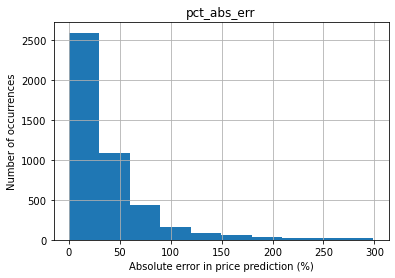

In [121]:
df_err_knn = df_pct_abs_err(y_pred_knn, y_train, plot=True)

In [122]:
df_err_knn['pct_abs_err'].median()

25.11902880376654

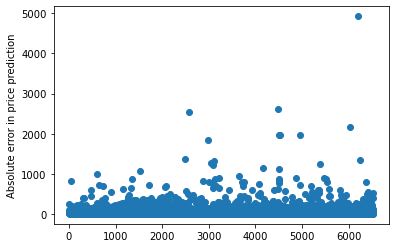

In [123]:
plt.plot(100*np.abs(y_train - y_pred_knn)/y_train, 'o')
plt.ylabel('Absolute fractional error in price prediction (\%)')
plt.show()

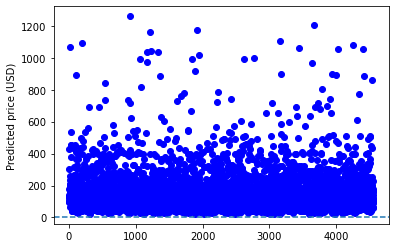

In [124]:
plt.plot(y_pred_knn, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

In [125]:
sum(y_pred_knn < 0)

0

None of the predictions are less than zero - a big advantage over the linear models.

What if I use the information I gained from the Elastic Net regression? That is, I will use the data with irrelevant features removed.

In [126]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_E_train, y_train, KNeighborsRegressor(weights='distance', p=1),
             cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 35.1, Standard error = 0.74, n_features = 4
Cutoff = 1, Mean score = 29.2, Standard error = 0.268, n_features = 38
Cutoff = 0.99, Mean score = 29.3, Standard error = 0.289, n_features = 40
Cutoff = 0.5, Mean score = 30.1, Standard error = 0.384, n_features = 69
Cutoff = 0.3, Mean score = 29.2, Standard error = 0.722, n_features = 75
Cutoff = 0.2, Mean score = 28, Standard error = 0.648, n_features = 78
Cutoff = 0.1, Mean score = 26.2, Standard error = 0.823, n_features = 86
Cutoff = 0.05, Mean score = 25.2, Standard error = 0.303, n_features = 98
Cutoff = 0.01, Mean score = 25.8, Standard error = 0.549, n_features = 165
Cutoff = 0.005, Mean score = 26.7, Standard error = 0.727, n_features = 204
Cutoff = 0.002, Mean score = 26.9, Standard error = 0.719, n_features = 242
Cutoff = 0.001, Mean score = 27.1, Standard error = 0.808, n_features = 298
Cutoff = 0.0005, Mean score = 27, Standard error = 0.696, n_features = 347
Cutoff = 0, Mean score = 27.1, Standard 

The scores are the same (within the standard errors of each other).

What if we use just the most important features, as determined from the `ElasticNet()` coefficients?

In [127]:
cutoffs = [1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_top_20_train, y_train, KNeighborsRegressor(weights='distance', p=1),
             cutoffs, scoring=median_scorer);

Cutoff = 1, Mean score = 39.7, Standard error = 0.584, n_features = 4
Cutoff = 0.99, Mean score = 39.7, Standard error = 0.584, n_features = 4
Cutoff = 0.5, Mean score = 35.6, Standard error = 0.549, n_features = 5
Cutoff = 0.3, Mean score = 35.6, Standard error = 0.549, n_features = 5
Cutoff = 0.2, Mean score = 35.6, Standard error = 0.549, n_features = 5
Cutoff = 0.1, Mean score = 33.7, Standard error = 0.545, n_features = 6
Cutoff = 0.05, Mean score = 33.9, Standard error = 0.324, n_features = 7
Cutoff = 0.01, Mean score = 32.5, Standard error = 0.461, n_features = 11
Cutoff = 0.005, Mean score = 32.5, Standard error = 0.551, n_features = 12
Cutoff = 0.002, Mean score = 32.5, Standard error = 0.431, n_features = 14
Cutoff = 0.001, Mean score = 32.1, Standard error = 0.552, n_features = 16
Cutoff = 0.0005, Mean score = 32.1, Standard error = 0.552, n_features = 16
Cutoff = 0, Mean score = 32, Standard error = 0.785, n_features = 20


This is actually worse. It seems that k-nearest neighbors uses the additional information from other features to good effect.

### Random Forest

In [128]:
from sklearn.ensemble import RandomForestRegressor

I will choose to use absolute error, instead of mean-squared error, as the criterion to minimize, since it is less sensitive to outliers.

In [129]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, RandomForestRegressor(n_estimators=10,
                                                     criterion='absolute_error',
                                                    random_state=42),
             cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 37.8, Standard error = 0.712, n_features = 4
Cutoff = 1, Mean score = 26.7, Standard error = 0.352, n_features = 38
Cutoff = 0.99, Mean score = 27.3, Standard error = 0.59, n_features = 40
Cutoff = 0.5, Mean score = 25.5, Standard error = 0.38, n_features = 70
Cutoff = 0.3, Mean score = 26.5, Standard error = 0.373, n_features = 76
Cutoff = 0.2, Mean score = 25.5, Standard error = 0.352, n_features = 79
Cutoff = 0.1, Mean score = 25.7, Standard error = 0.341, n_features = 87
Cutoff = 0.05, Mean score = 25.6, Standard error = 0.301, n_features = 99
Cutoff = 0.01, Mean score = 24.5, Standard error = 0.3, n_features = 166
Cutoff = 0.005, Mean score = 24.3, Standard error = 0.375, n_features = 205
Cutoff = 0.002, Mean score = 24.1, Standard error = 0.341, n_features = 246
Cutoff = 0.001, Mean score = 23.6, Standard error = 0.406, n_features = 304
Cutoff = 0.0005, Mean score = 24.1, Standard error = 0.237, n_features = 361
Cutoff = 0, Mean score = 23.9, Standard

array([22.90322581, 21.8852459 , 25.27377522, 24.43181818, 24.82647059])

This is significantly more computationally expensive to train than k-nearest neighbors (it took about a hundred times as long on my laptop), but it performs no better.

In [130]:
y_pred_rf = fit_model(X_train, y_train, RandomForestRegressor(
    n_estimators=10, criterion='absolute_error', random_state=42), cutoff=0)

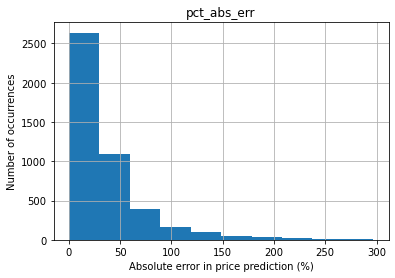

In [131]:
df_err_rf = df_pct_abs_err(y_pred_rf, y_train, plot=True)

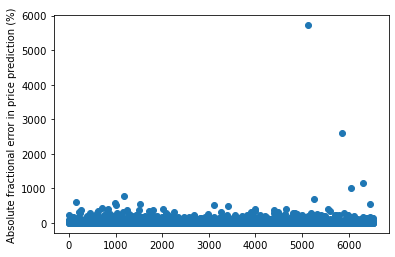

In [132]:
plt.plot(100*np.abs(y_train - y_pred_rf)/y_train, 'o')
plt.ylabel('Absolute fractional error in price prediction (\%)')
plt.show()

## Final Evaluation and Deployment

It's time to stop holding back the test set.

In [204]:
def do_final_fit(X_train, y_train, X_test, y_test, model, cutoff):
    pipe = make_pipeline(StandardScaler(), model)
    to_keep = np.where(np.abs(X_train.sum()/len(X_train)) > cutoff)[0]
    X_train_cutoff = X_train.iloc[:, to_keep]
    X_test_cutoff = X_test.iloc[:, to_keep]
    pipe.fit(X_train_cutoff, y_train)
    y_pred = pipe.predict(X_test_cutoff)
    score = median_abs_pct_err(y_test, y_pred)
    return pipe, score

In [161]:
pipe_LM, score_LM = do_final_fit(X_train, y_train, X_test, y_test, 
                                 LinearRegression(), 0.001)
print(f"Median absolute fractional error, using best linear model of my initial kind = {score_LM:.3g}%")

Median absolute fractional error, using best linear model of my initial kind = 37.4%


In [162]:
pipe_SLM, score_SLM = do_final_fit(X_small_train, y_small_train, X_small_test, y_small_test, 
                                 LinearRegression(), 0)
print(f"Median absolute fractional error, using best \"smaller linear model\" = {score_SLM:.3g}%")

Median absolute fractional error, using best "smaller linear model" = 32.7%


In [163]:
pipe_EN, score_EN = do_final_fit(X_small_train, y_small_train, X_small_test, y_small_test, 
                                 ElasticNet(), 0)
print(f"Median absolute fractional error, using best \"small linear model\" = {score_EN:.3g}%")

Median absolute fractional error, using best "small linear model" = 33%


In [208]:
pipe_KNN, score_KNN = do_final_fit(X_train, y_train, X_test, y_test, 
                                 KNeighborsRegressor(n_neighbors=3,
                                                     weights='distance', p=1), 0.05)
print(f"Median absolute fractional error, using best k-nearest neighbors model = {score_KNN:.3g}%")

Median absolute fractional error, using best k-nearest neighbors model = 20.6%


In [169]:
pipe_RF, score_RF = do_final_fit(X_train, y_train, X_test, y_test, 
                                 RandomForestRegressor(n_estimators=10,
                                                       criterion='absolute_error',
                                                       random_state=42), 0)
print(f"Median absolute fractional error, using best random forest model = {score_RF:.3g}%")

Median absolute fractional error, using best random forest model = 23.2%


My best model, as judged by the median fractional error, is a k-nearest neighbors model with
3 neighbors, points weighted by the inverse of their distance, and using the taxicab metric as opposed to the Euclidean metric. I think it's a reasonable attempt at a pricing model for a short project; for 50% of listings in the test set, it's off from the true listed price by less than 21%.

To deploy the model, I first train it on the full set of data (train and test):

In [53]:
cutoff = 0.05
X_cutoff = X.iloc[:, np.where(np.abs(X.sum()/len(X)) > cutoff)[0]]
cols_after_cutoff = X_cutoff.columns
pipe_deployed = make_pipeline(StandardScaler(), 
                     KNeighborsRegressor(weights='distance', p=1))
pipe_deployed.fit(X_cutoff, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(p=1, weights='distance'))])

To make predictions on new data, I need to prepare the data as I prepared X. It will be useful to have a pipeline to do this. The following function, `data_prep_pipeline`, takes a csv file with listings I want to price and generates the fully cleaned X matrix with all features.

In [180]:
def data_prep_pipeline(csv_file):
    
    listings = pd.read_csv(csv_file)
    # Drop columns that were all NA in X
    listings.drop(columns=listings_na_cols, inplace=True)
    # Deal with percent signs in some columns
    listings['host_response_rate'] = listings.apply(lambda x: 
                                                    float(x['host_response_rate'].
                                                          replace('%','')) if 
                                                    pd.notnull(x['host_response_rate'])
                                                    else x['host_response_rate'], axis=1)
    listings['host_acceptance_rate'] = listings.apply(lambda x: 
                                                      float(x['host_acceptance_rate'].
                                                            replace('%','')) if 
                                                      pd.notnull(x['host_acceptance_rate']) 
                                                      else x['host_acceptance_rate'],
                                                      axis=1)

    # Create X by removing the 'price' field
    X = listings.drop('price', axis=1)

    # Convert timestamps to lengths of time
    for col in ['host_since', 'first_review', 'last_review']:
        X[col] = pd.to_datetime(X['last_scraped']) - pd.to_datetime(X[col])
        X[col] = X.apply(lambda x: x[col].days, axis=1)

    # Drop irrelevent features
    to_drop = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name']
    to_drop += ['description', 'neighborhood_overview', 'picture_url', 'host_id']
    to_drop += ['host_url', 'host_name', 'host_about', 'host_thumbnail_url']
    to_drop += ['host_picture_url', 'license', 'calendar_last_scraped']
    X.drop(labels=to_drop, axis=1, inplace=True)

    # Make the 'host_verifications' and 'amenities' columns into lists
    # instead of strings
    X['host_verifications'] = X.apply(lambda x: x['host_verifications'].replace('[','').
                                      replace(']','').replace('\'','').split(', '), axis=1)
    X['amenities'] = X.apply(lambda x: x['amenities'].replace('\"','').replace('[','').
                             replace(']','').split(', '), axis=1)
    
    # I found the distinct `host_verifications` options in the Data Preparation
    # section. Now I can use a `MultiLabelBinarizer` to make a dummy column
    # for each option in `host_verifications`
    mlb_hv = MultiLabelBinarizer()
    mlb_hv.fit([distinct_host_verifications])
    hv_df = pd.DataFrame(mlb_hv.transform(X['host_verifications']), 
                      columns=mlb_hv.classes_, index=X.index)
    X = pd.concat([X, hv_df], axis=1)
    X.rename(columns={'None' : 'HV_None'}, inplace=True)
    X.drop('host_verifications', axis=1, inplace=True)
    
    # I found the top 20 amenities in my Data Preparation section above,
    # and defined `find_amenities(x)` to take a row x and keep only the 
    # amenities that are in the top 20
    X['amenities'] = X.apply(lambda x: find_amenities(x), axis=1)
    
    # In the same way as `host_verifications`, now split the different
    # amenities into their own dummy variables
    mlb_amenities = MultiLabelBinarizer()
    mlb_amenities.fit([top_20_amenities])
    amenities_df = pd.DataFrame(mlb_amenities.transform(X['amenities']),
                                columns=mlb_amenities.classes_, index=X.index)
    X = pd.concat([X, amenities_df], axis=1)
    X.drop('amenities', axis=1, inplace=True)
    
    # Now get dummy variables for the rest of the categorical features
    # I created `one_hot` in the Data Preparation section
    X_cat = X[cat_columns].copy()
    X_cat.fillna(value="NA", inplace=True)
    X_onehot = pd.DataFrame(one_hot.transform(X_cat),
                            columns=one_hot.get_feature_names_out(),
                           index = X.index)
    X.drop(columns=cat_columns, inplace=True)
    X = pd.concat([X, X_onehot], axis=1)
    
    # For numerical features that are NA, impute using the column means from X
    X.fillna(value=X_col_means, inplace=True)
    
    return X

Finally, I use the fitted model from above, `pipe_deployed`, and the appropriate columns of X, `cols_after_cutoff`, for that fitted model to make the price prediction.

In [184]:
def predict_price(X, pipe_deployed, cols_after_cutoff):
    X_cutoff = X[cols_after_cutoff]
    price = pipe_deployed.predict(X_cutoff)[0]
    return price

Now let's say I bought a property in Chicago that I want to list on Airbnb. What should I price it to be in line with typical prices for such a property?

My hypothetical property is a rental unit with two bedrooms and two bathrooms. It can accommodate four people (one bed per room), is in Hyde Park, and has reasonable amenities. I might guess I should price it around USD 200 per night.

In [187]:
X_my = data_prep_pipeline('my_listing.csv')

In [188]:
predict_price(X_my, pipe_deployed, cols_after_cutoff)

245.4280281239614

So according to my best model, to be in line with typical pricing strategy, I should price my apartment at about USD 245 per night, just a little higher than what I expected.

Finding the **best** price for a given night, i.e. the one that maximizes the expected return (the price times the probability that it is booked that night) is a different problem. It seems to me that a significantly more sophisticated model would need to be developed to do this in a reasonable way throughout the year - perhaps a good future project.